In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/generative-dog-images/all-dogs.zip
/kaggle/input/generative-dog-images/Annotation.zip


# RaLSGAN on DOG images
We are implementing Relativistic Average Least Square GAN on dog images which is hosted on kaggle. Dont get scared by the title. Basically we are implementing DCGAN or Deep Convolution GAN on the dog dataset. However it is inefficient and will take a lot of time and memory. There are several key things to take care about - 
+ No fully connected layers in both the networks
+ ReLU for generator Leaky for Discriminator
+ Batch Norm between layers ensuring no mode collapse
+ Instead of pooling, strided conv(discriminator) and fractional strided conv(generator)

Now we use an improved loss function. Till now we have ensured that the generator improves the probability to fool the discriminator. However, in order to stabilize it, we introduce RaLSGAN which is an improvement over the loss function. Now what we do is that we also decrease the probability of a real image being real. This not only stabilizes it but reduces training time as it doesnt require multiple updates on discriminator for a single update on generator. We are also able to scale easily from 64x64 to 256x256. Read more [here](https://www.kaggle.com/c/generative-dog-images/discussion/99485)

In [2]:
from __future__ import print_function
import time
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.utils as vutils
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from PIL import Image

In [7]:
import zipfile



# Will unzip the files so that you can see them..
with zipfile.ZipFile("../input/generative-dog-images/all-dogs.zip","r") as z:
    z.extractall(".")
# !ls ../input/generative-dog-images/

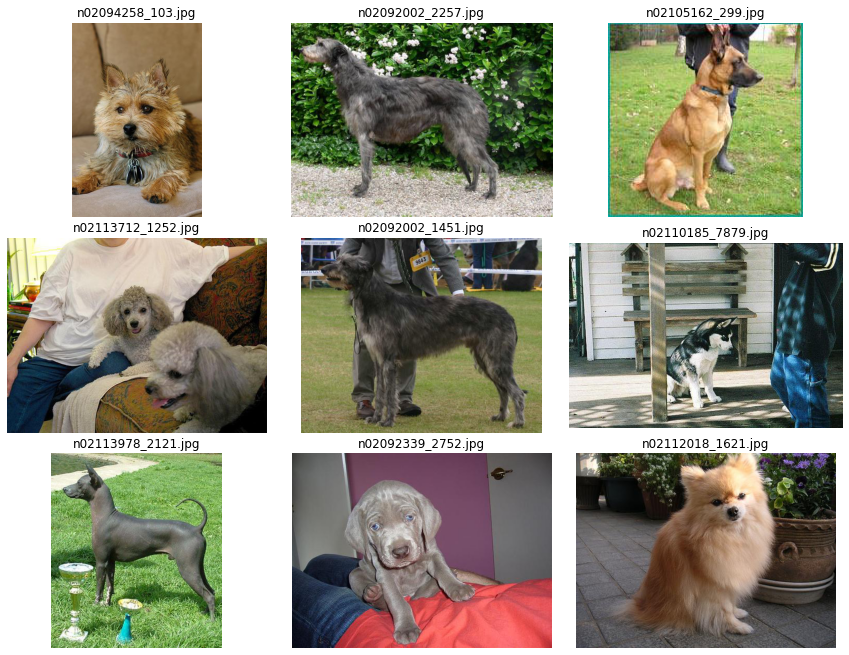

In [10]:
images = os.listdir('all-dogs/')
fig, axes = plt.subplots(3,3,figsize=(12,10))
for indx, axis in enumerate(axes.flatten()):
#     rnd_indx = np.random.randint(0, len(os.listdir(PATH)))
    img = plt.imread("all-dogs/"+images[indx])
    imgplot = axis.imshow(img)
    axis.set_title(images[indx])
    axis.set_axis_off()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

## Insights
Although it is not very important but the dataset contains imbalanced classes of dogs as well as images with dogs having distinguishible background. In some of the images, there are humans holding the dogs. You can read more about them [here](https://www.kaggle.com/witold1/quick-data-explanation-and-eda)

In [41]:
class DogDataset(Dataset):
    def __init__(self, img_dir, transform1=None, transform2=None):
    
        self.img_dir = img_dir
        self.img_names = os.listdir(img_dir)
        self.transform1 = transform1
        self.transform2 = transform2
        
        self.imgs = []
        for img_name in self.img_names:
            img = Image.open(os.path.join(img_dir, img_name))
            
            if self.transform1 is not None:
                img = self.transform1(img)
                
            self.imgs.append(img)

    def __getitem__(self, index):
        img = self.imgs[index]
        
        if self.transform2 is not None:
            img = self.transform2(img)
        
        return img

    def __len__(self):
        return len(self.imgs)

We read the entire data into RAM for faster I/O. Therefore it will take time initially. Note: This is not desirable

In [42]:
batch = 32
img_size = 64
transform1 = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64)])

# Data augmentation and converting to tensors
random_transforms = [transforms.RandomRotation(degrees=5)]
transform2 = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.RandomApply(random_transforms, p=0.3), 
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                                 
train_dataset = DogDataset(img_dir='all-dogs/',
                           transform1=transform1,
                           transform2=transform2)

                          transform1=transformy)


In [43]:
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True,
                                           batch_size=batch, num_workers=4)
imgs = next(iter(train_loader))
imgs = imgs.numpy().transpose(0,2,3,1)

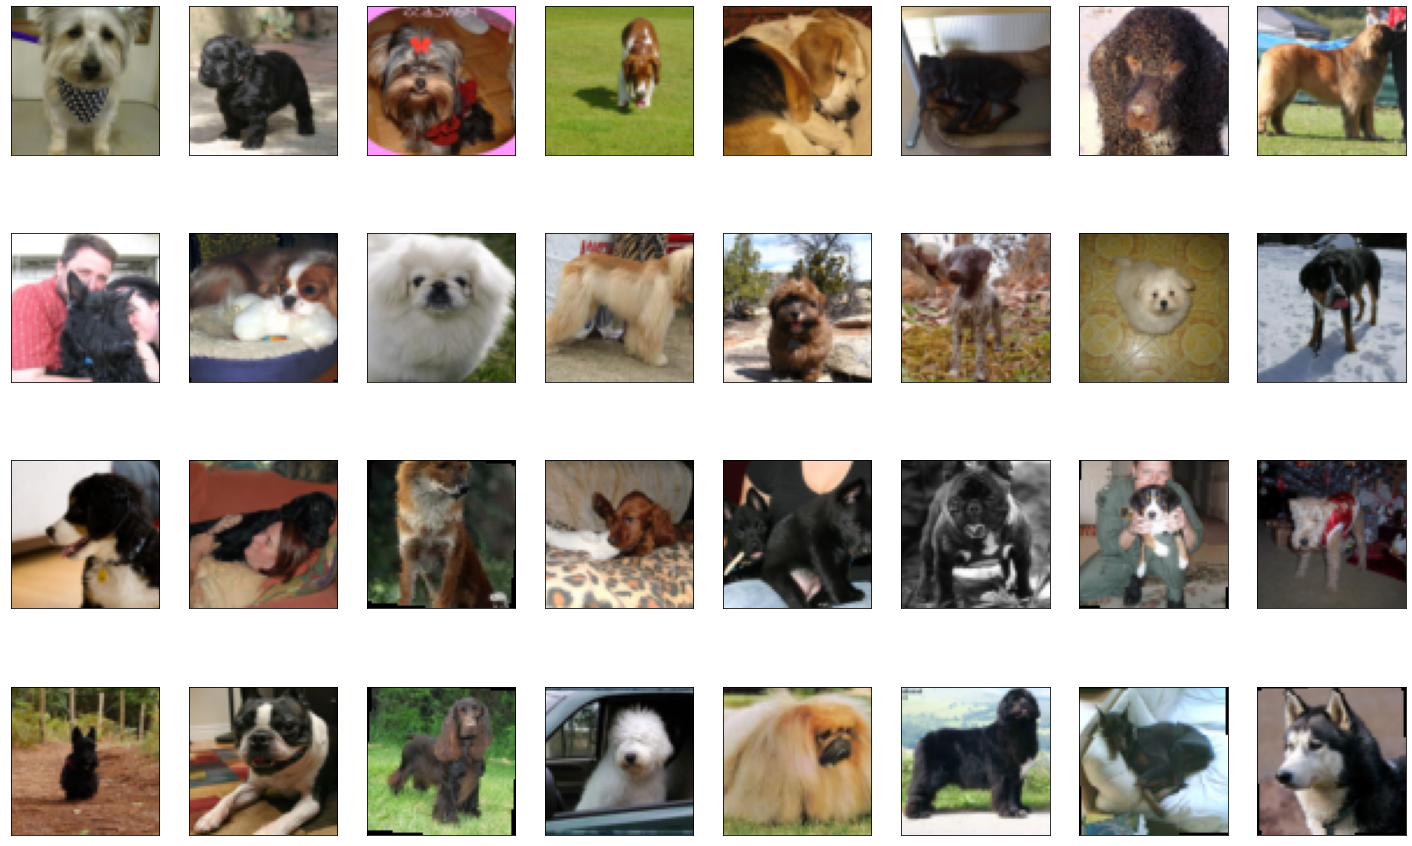

In [45]:
# Images after augmentation and all the changes
fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(imgs):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    
    plt.imshow((img+1)/2)

In [152]:
lr = 2e-4
beta1 = 0.5


# Note in standard gan, it would have been 1
real_label = 0.9
fake_label = 0
# size of the latent space
nz = 128

## Models

In [148]:
# Special exception keeping leaky relu as its performing well
class Generator(nn.Module):
    def __init__(self,nz=128,channels=3):
        super(Generator,self).__init__()
        self.nz = nz
        self.channels = channels
        self.kernel = 4
        self.stride = 2
        self.padding = 1
        self.hidden0 = nn.Sequential(nn.ConvTranspose2d(self.nz,1024,kernel_size = self.kernel,stride = self.stride,padding=0,bias=False),
                                    nn.BatchNorm2d(1024),
                                    nn.LeakyReLU(0.2,inplace=True))
        self.hidden1 = nn.Sequential(nn.ConvTranspose2d(1024,512,kernel_size = self.kernel,stride = self.stride,padding=self.padding,bias=False),
                                    nn.BatchNorm2d(512),
                                    nn.LeakyReLU(0.2,inplace=True))
        self.hidden2 = nn.Sequential(nn.ConvTranspose2d(512,256,kernel_size = self.kernel,stride = self.stride,padding=self.padding,bias=False),
                                    nn.BatchNorm2d(256),
                                    nn.LeakyReLU(0.2,inplace=True),
                                    nn.Dropout(p=0.25))
        self.hidden3 = nn.Sequential(nn.ConvTranspose2d(256,128,kernel_size = self.kernel,stride = self.stride,padding=self.padding,bias=False),
                                    nn.BatchNorm2d(128),
                                    nn.LeakyReLU(0.2,inplace=True),
                                    nn.Dropout(0.25))
        self.hidden4 = nn.Sequential(nn.ConvTranspose2d(128,64,kernel_size = self.kernel,stride = self.stride,padding=self.padding,bias=False),
                                    nn.BatchNorm2d(64),
                                    nn.LeakyReLU(0.2,inplace=True),
                                    nn.Dropout(0.25))
        self.output = nn.Sequential(nn.ConvTranspose2d(64,self.channels,kernel_size = 3,stride = 1,padding=1),
                                    nn.Tanh())
    def forward(self,z):
        z = z.view(-1,self.nz,1,1)
        z = self.hidden0(z)
        z = self.hidden1(z)
        z = self.hidden2(z)
        z = self.hidden3(z)
        z = self.hidden4(z)
        z = self.output(z)
        return z


In [149]:
# Typically in DCGAN, the last layer is the FCNN with sigmoid, however in this case its not working
class Discriminator(nn.Module):
    def __init__(self,channels=3):
        super(Discriminator,self).__init__()
        
        self.channels = channels
        self.kernel = 4
        self.stride = 2
        self.padding = 1
        self.hidden0 = nn.Sequential(nn.Conv2d(self.channels,32,kernel_size=self.kernel,stride=self.stride,padding=self.padding,bias=False),
                                    nn.LeakyReLU(0.2,inplace=True))
        self.hidden1 = nn.Sequential(nn.Conv2d(32,64,kernel_size=self.kernel,stride=self.stride,padding=self.padding,bias=False),
                                    nn.LeakyReLU(0.2,inplace=True))
        self.hidden2 = nn.Sequential(nn.Conv2d(64,128,kernel_size=self.kernel,stride=self.stride,padding=self.padding,bias=False),
                                    nn.BatchNorm2d(128),
                                     nn.LeakyReLU(0.2,inplace=True))
        self.hidden3 = nn.Sequential(nn.Conv2d(128,256,kernel_size=self.kernel,stride=self.stride,padding=self.padding,bias=False),
                                    nn.BatchNorm2d(256),
                                     nn.LeakyReLU(0.2,inplace=True))
        self.output = nn.Sequential(nn.Conv2d(256,1,kernel_size=self.kernel,stride=1,padding=0,bias=False),
                                   )
        self.out = nn.Sequential(
            nn.Linear(256*4*4, 1),
            nn.Sigmoid(),
        )
    def forward(self,x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        logits = self.output(x)
#         x = x.view(-1, 256*4*4)
#         x = self.out(x)
#         out = torch.sigmoid(logits)
        return logits.view(-1,1)


In [109]:
def show_generated_img(title):
    noise = torch.randn(1, nz, 1, 1, device=device)
    gen_image = netG(noise).to("cpu").clone().detach().squeeze(0)
    gen_image = gen_image.numpy().transpose(1, 2, 0)
    plt.title(title)
    plt.imshow((gen_image+1)/2)
    plt.axis('off')
#     plt.savefig('results/'+title+'.png')
    plt.show()

In [150]:
def weights_init(m):
    """
    Takes as input a neural network m that will initialize all its weights.
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


netG = Generator(nz).to(device)
netG.apply(weights_init)
netD = Discriminator().to(device)
netD = netD.to(device)

n_epochs = 1000
criterion = nn.BCELoss()
doptim = optim.Adam(netD.parameters(), lr=2*lr, betas=(beta1, 0.999))
goptim = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


[1/300][322/644] Loss_D: 0.1350 Loss_G: 2.7538
[1/300][644/644] Loss_D: 0.2420 Loss_G: 0.6335



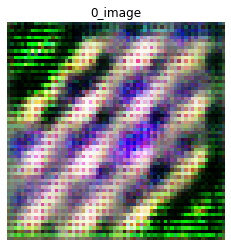

[2/300][322/644] Loss_D: 0.0804 Loss_G: 3.6255
[2/300][644/644] Loss_D: 0.2673 Loss_G: 7.0603



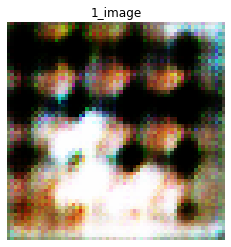

[3/300][322/644] Loss_D: 0.2119 Loss_G: 4.0500
[3/300][644/644] Loss_D: 0.3864 Loss_G: 6.9285



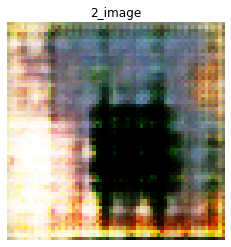

[4/300][322/644] Loss_D: 0.1245 Loss_G: 4.3858
[4/300][644/644] Loss_D: 0.1783 Loss_G: 6.0525



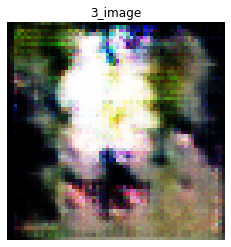

[5/300][322/644] Loss_D: 0.4960 Loss_G: 4.3241
[5/300][644/644] Loss_D: 0.2976 Loss_G: 7.8574



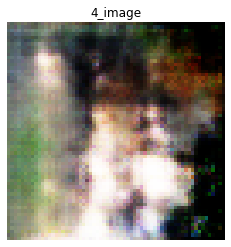

[6/300][322/644] Loss_D: 0.2459 Loss_G: 2.8616
[6/300][644/644] Loss_D: 4.7714 Loss_G: 12.3950



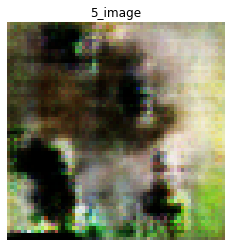

[7/300][322/644] Loss_D: 0.2184 Loss_G: 4.6278
[7/300][644/644] Loss_D: 1.3085 Loss_G: 16.0330



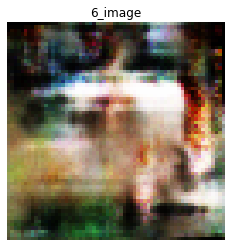

[8/300][322/644] Loss_D: 0.2856 Loss_G: 2.9917
[8/300][644/644] Loss_D: 0.2851 Loss_G: 8.3103



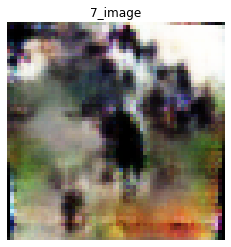

[9/300][322/644] Loss_D: 0.1490 Loss_G: 3.5215
[9/300][644/644] Loss_D: 0.1159 Loss_G: 1.1289



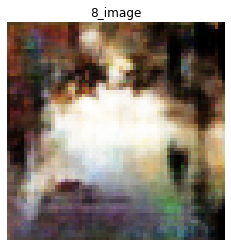

[10/300][322/644] Loss_D: 0.1217 Loss_G: 3.3569
[10/300][644/644] Loss_D: 1.2230 Loss_G: 11.9601



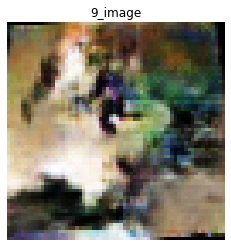

In [153]:
for epoch in range(n_epochs):
    
    for ii, real_images in tqdm(enumerate(train_loader), total=len(train_loader)):
        ############################
        # (1) Update D network
        ###########################
        netD.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size, 1), real_label, device=device)
        outputR = netD(real_images)
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        outputF = netD(fake.detach())
        errD = (torch.mean((outputR - torch.mean(outputF) - labels) ** 2) + 
                torch.mean((outputF - torch.mean(outputR) + labels) ** 2))/2
        errD.backward(retain_graph=True)
        doptim.step()
        ############################
        # (2) Update G network
        ###########################
        netG.zero_grad()
        outputF = netD(fake)   
        errG = (torch.mean((outputR - torch.mean(outputF) + labels) ** 2) +
                torch.mean((outputF - torch.mean(outputR) - labels) ** 2))/2
        errG.backward()
        goptim.step()
        
        if (ii+1) % (len(train_loader)//2) == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f'
                  % (epoch + 1, epochs, ii+1, len(train_loader),
                     errD.item(), errG.item()))

    show_generated_img('%s_image'%epoch)

## Visualize Generated Results

In [146]:
gen_z = torch.randn(32, nz, 1, 1, device=device)
gen_images = (netG(gen_z).to("cpu").clone().detach() + 1)/2
gen_images = gen_images.numpy().transpose(0, 2, 3, 1)

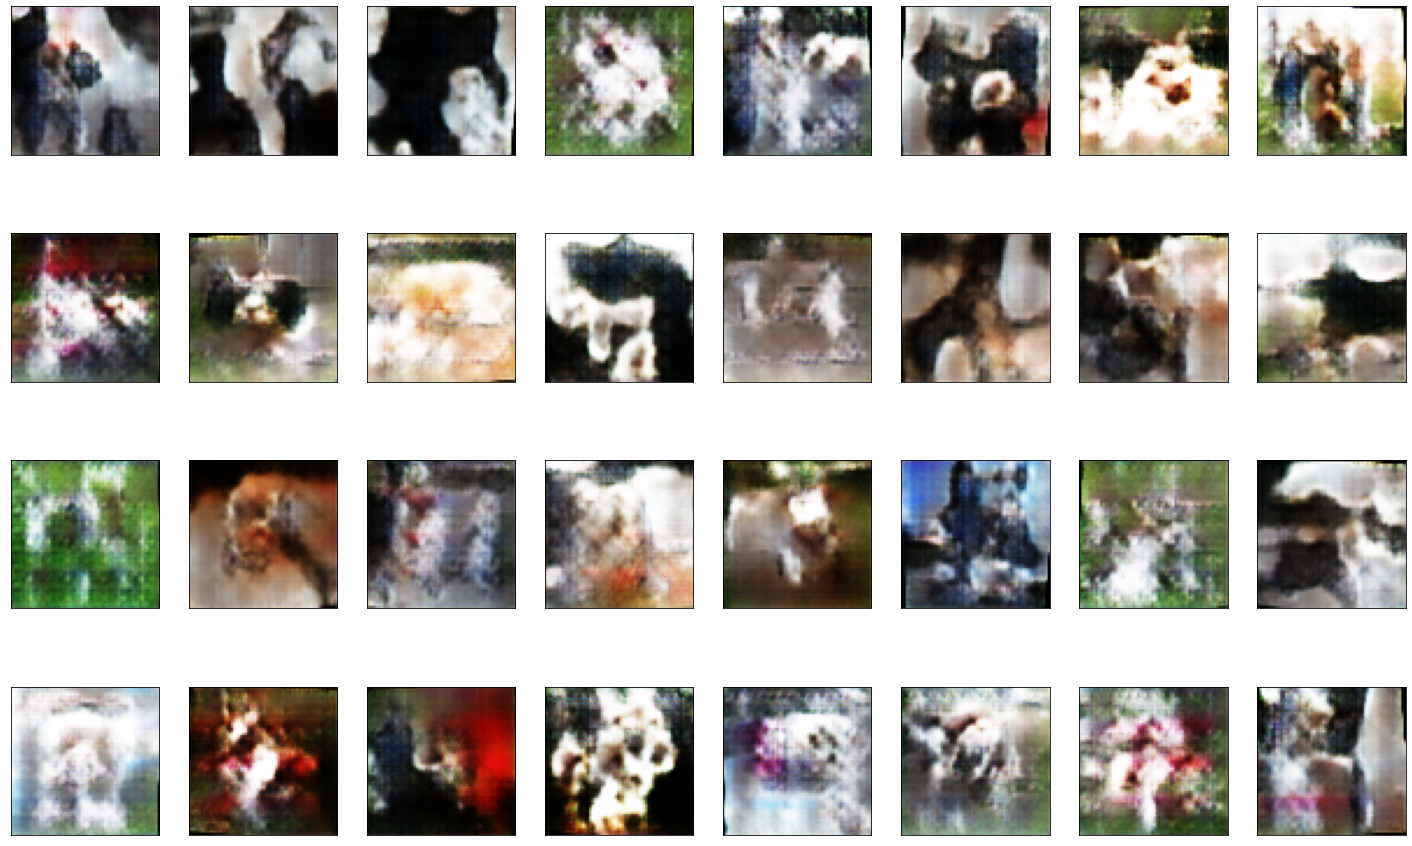

In [147]:
fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(gen_images):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow(img)

## Make Prediction

In [107]:
if not os.path.exists('../output_images'):
    os.mkdir('../output_images')
im_batch_size = 50
n_images=100
for i_batch in range(0, n_images, im_batch_size):
    gen_z = torch.randn(im_batch_size, nz, 1, 1, device=device)
    gen_images = (netG(gen_z) + 1)/2
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('../output_images', f'image_{i_batch+i_image:05d}.png'))


import shutil
shutil.make_archive('images', 'zip', '../output_images')

'/kaggle/working/images.zip'

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)